## Imports and Setup

In [2]:
%matplotlib inline
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from   sklearn.decomposition import TruncatedSVD
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from   sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [3]:
# class corpus metadata
metadata = pd.read_csv("class_corpus_metadata.csv")

metadata.shape

(160, 34)

In [4]:
metadata.head()

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,feminist fiction,mystery,adventure,tragedy,children,regency,manners,philosophical,coming-of-age,filename
0,nsg57,scw222,lcc82,"Writings in the United Amateur, 1915 - 1922",1922,Lovecraft,Howard,NaN,NaN,Male,...,False,True,False,False,False,False,False,True,False,Lovecraft_WritingsintheUnitedAmateur1915-1922.txt
1,fhh26,gs542,tj256,Whose Body?,1923,Sayers,Dorothy L.,NaN,NaN,Female,...,False,True,False,False,False,False,False,False,False,Sayres_WhoseBody.txt
2,cl2264,NaN,NaN,Voodoo Planet,1959,Norton,Andre,NaN,NaN,Female,...,False,False,True,False,False,False,False,False,False,Norton_VoodooPlanet.txt
3,ehh52,sjr255,kg428,"Varney the Vampire; Or, the Feast of Blood by ...",1845,Rymer,James Malcolm,Prest,Thomas Peckett,Male,...,False,False,False,False,False,False,False,False,False,Prest_Rhymer_VarneyTheVampire.txt
4,dgr73,jlp367,kg428,Uncle Tom's Cabin,1852,Stowe,Harriet Beecher,NaN,NaN,Female,...,False,False,False,False,False,False,False,False,False,Stowe_UncleTom_sCabin.txt


In [5]:
# training data are books that are either horror or detective
training_data = metadata[(metadata['horror']==True) | (metadata['detective']==True)]

# drop books that are both horror and detective
drop = metadata[(metadata['horror']==True) & (metadata['detective']==True)]
training_data = training_data.drop(drop.index)

# testing data are books are neither horror or detective
testing_data = metadata[(metadata['horror']==False) & (metadata['detective']==False)]

# sort titles alphabetically 
training_data = training_data.sort_values('title')
testing_data = testing_data.sort_values('title')
# note: training+testing+dropped row = 159 rows, class corpus = 160 rows, "An Unkindness of Ghosts" has no input for horror and detective column

In [6]:
training_data=training_data.reset_index(drop=True)
training_data

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,feminist fiction,mystery,adventure,tragedy,children,regency,manners,philosophical,coming-of-age,filename
0,tl566,hz542,ja532,813,1910,Leblanc,Maurice,NaN,NaN,Male,...,False,True,False,False,False,False,False,False,False,Leblanc_813.txt
1,gc386,NaN,NaN,A Strange Disappearance,1998,Green,Anna Katharine,NaN,NaN,Female,...,False,True,False,False,False,False,False,False,False,GreenAnnaKatharine_AStrangeDisappearance.txt
2,nca28,tl566,stw43,A Study in Scarlet,1887,Conan Doyle,Arthur,NaN,NaN,Male,...,False,True,False,False,False,False,False,False,False,ConanDoyle_AStudyInScarlet.txt
3,jc2739,NaN,NaN,Agatha Webb,1899,Green,Anna Katharine,NaN,NaN,Female,...,False,True,False,False,False,False,False,False,False,Green_AgathaWebb.txt
4,lcc82,yk499,NaN,Carmilla,1872,Le_Fanu,Joseph Sheridan,NaN,NaN,Male,...,False,False,False,False,False,False,False,False,False,Carmilla.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,tr333,sjs457,sl2324,The Valley of Fear,1915,Doyle,Arthur Conan,NaN,NaN,Male,...,False,False,False,False,False,False,False,False,False,Doyle_TheValleyOfFear.txt
76,lrs263,sh785,hz542,The Wisdom of Father Brown,1914,Chesterton,Gilbert Keith,NaN,NaN,Male,...,False,False,False,False,False,False,False,False,False,Chesterton_TheWisdomOfFatherBrown.txt
77,ehh52,sjr255,kg428,"Varney the Vampire; Or, the Feast of Blood by ...",1845,Rymer,James Malcolm,Prest,Thomas Peckett,Male,...,False,False,False,False,False,False,False,False,False,Prest_Rhymer_VarneyTheVampire.txt
78,fhh26,gs542,tj256,Whose Body?,1923,Sayers,Dorothy L.,NaN,NaN,Female,...,False,True,False,False,False,False,False,False,False,Sayres_WhoseBody.txt


### There are 80 combined horror and detective novels in the corpus that we will use to train the classifier.

In [7]:
testing_data=testing_data.reset_index(drop=True)
testing_data

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,feminist fiction,mystery,adventure,tragedy,children,regency,manners,philosophical,coming-of-age,filename
0,tr333,sjs457,sl2324,A Round Dozen,1883,Coolidge,Susan,NaN,NaN,Female,...,False,False,False,False,False,False,False,False,False,Coolidge_ARoundDozen.txt
1,kwy3,cl922,hk627,A Sicillian Romance,1790,Radcliffe,Ann Ward,NaN,NaN,Female,...,False,False,False,False,False,False,False,False,False,radcliffeann_a_sicillian_romance.txt
2,lqz4,gt294,lcc82,Adele Doring at Boarding-School,1921,North,Grace May,NaN,NaN,Female,...,False,False,False,False,True,False,False,False,False,adele_doring_boarding_school.txt
3,yc2669,xf89,wms87,Agnes Grey,1847,Bronte,Anne,NaN,NaN,Female,...,True,False,False,False,False,False,True,False,False,Bronte_AgnesGrey.txt
4,mn454,ar2465,jlp367,An Old-Fashioned Girl,1869,Alcott,Louisa May,NaN,NaN,Female,...,False,False,False,False,True,False,True,False,True,Alcott_AnOld-FashionedGirl.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,jc2739,NaN,NaN,This Side of Paradise,1920,Fitzgerald,F. Scott,NaN,NaN,Male,...,False,False,False,False,False,False,False,False,True,Fitzgerald_ThisSideOfParadise.txt
74,vs339,thh55,NaN,To Kill A Mockingbird,1960,Lee,Harper,NaN,NaN,Female,...,False,False,False,False,False,False,False,False,False,Lee_ToKillAMockingbird.txt
75,fhh26,gs542,tj256,Twenty Thousand Leagues Under the Sea,1870,Verne,Jules,NaN,NaN,Male,...,False,False,True,False,False,False,False,False,False,Verne_TwentyThousandLeagues.txt
76,dgr73,jlp367,kg428,Uncle Tom's Cabin,1852,Stowe,Harriet Beecher,NaN,NaN,Female,...,False,False,False,False,False,False,False,False,False,Stowe_UncleTom_sCabin.txt


### There are 78 combined novels from a variety of genres that are not horror or detective in the corpus.

In [8]:
# get book file names to open
training_names = training_data.filename.values
testing_names = testing_data.filename.values

In [9]:
print('First book in the training dataset:',training_names[0])
print('First book in the testing dataset:',testing_names[0])

First book in the training dataset: Leblanc_813.txt
First book in the testing dataset: Coolidge_ARoundDozen.txt


In [10]:
# 1=detective, 0=horror， gold labels
y_train=(training_data.detective.values*1).astype('int')

In [11]:
y_train

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0])

In [12]:
# open and append training books together

training_books=[]
for book in training_names:
    with open(book, 'r',encoding='utf-8') as f:
        file = f.read().replace("\n", " ") 
        training_books.append(file)
        

In [13]:
# open and append testing books together

testing_books=[]
for book in testing_names:
    with open(book, 'r',encoding='utf-8') as f:
        file = f.read().replace("\n", " ") 
        testing_books.append(file)
        

### Vectorization, stopwords, normalization, standardization
an explanation. we really did try to not do arbitrary things

In [13]:
punct=[]
for x in string.punctuation:
    punct.append(x)
punct.append('--')
punct.append('`')
punct.append("“")
punct.append("”")

In [14]:
# Custom preprocessing to remove escaped characters in input, taken from MP02
def pre_proc(x):
    '''
    Takes a unicode string.
    Lowercases, strips accents, and removes some escapes.
    Returns a standardized version of the string.
    '''
    import unicodedata
    return unicodedata.normalize('NFKD', x.replace("\'", "'").replace("\ in\ form", " inform").lower().strip())

# Set up vectorizer

vectorizer = TfidfVectorizer(
    encoding='utf-8',
    preprocessor=pre_proc,
   # stop_words=punct,
    min_df=2, # Note this
    max_df=0.8, # This, too
    binary=False,
    norm='l2',
    use_idf=True, # And this,
    #max_features=10000
)

# Your code here
X_train = vectorizer.fit_transform(training_books)
print("Matrix shape:", X_train.shape)

Matrix shape: (80, 30376)


In [15]:
#standardization
X_train_Z = StandardScaler(with_mean=False).fit_transform(X_train)
display(X_train_Z)
print('z-scored l2 mean:', round(np.mean(X_train_Z),3))
#np.std(X_train)

<80x30376 sparse matrix of type '<class 'numpy.float64'>'
	with 376031 stored elements in Compressed Sparse Row format>

z-scored l2 mean: 0.292


## Classifier

We are choosing Multinomial NB, logistic, for reasons x and y. our thought process cuz we shouldnt use the multinomial because you should appreciate that we are actually thinking instead of copying and pasting mp 02 thank you
we are smart and realize that class_prior is not good for reasons

In [16]:
# Examine the performance of our simple classifiers
# Freebie function to summarize and display classifier scores

#soure: mp2
def compare_scores(scores_dict):
    '''
    Takes a dictionary of cross_validate scores.
    Returns a color-coded Pandas dataframe that summarizes those scores.
    '''
    df = pd.DataFrame(scores_dict).T.applymap(np.mean).style.background_gradient(cmap='RdYlGn')
    return df

In [17]:
vect_n=[]
matrix_n= {}
feat_n = [5000,10000,15000,17500,20000,22500,25000,30000,35000]
for x in feat_n:
    vectorizer = TfidfVectorizer(
        encoding='utf-8',
        preprocessor=pre_proc,
        min_df=2, # Note this
        max_df=0.8, # This, too
        binary=False,
        norm='l2',
        use_idf=True, # And this
        max_features=x)
    vect_n.append(vectorizer)
    matrix = vectorizer.fit_transform(training_books)
    X_train_Z = StandardScaler(with_mean=False).fit_transform(matrix)
    dict_key=str(x)
    matrix_n[dict_key] = X_train_Z

In [18]:
matrix_n

{'5000': <80x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 187794 stored elements in Compressed Sparse Row format>,
 '10000': <80x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 274957 stored elements in Compressed Sparse Row format>,
 '15000': <80x15000 sparse matrix of type '<class 'numpy.float64'>'
 	with 320917 stored elements in Compressed Sparse Row format>,
 '17500': <80x17500 sparse matrix of type '<class 'numpy.float64'>'
 	with 335934 stored elements in Compressed Sparse Row format>,
 '20000': <80x20000 sparse matrix of type '<class 'numpy.float64'>'
 	with 347813 stored elements in Compressed Sparse Row format>,
 '22500': <80x22500 sparse matrix of type '<class 'numpy.float64'>'
 	with 357000 stored elements in Compressed Sparse Row format>,
 '25000': <80x25000 sparse matrix of type '<class 'numpy.float64'>'
 	with 364318 stored elements in Compressed Sparse Row format>,
 '30000': <80x30000 sparse matrix of type '<class 'numpy.float64'>'
 	with 375

#### Multinomial Naive Bayes

In [19]:
nb_classifiers = {
    'M NB Default, Alpha=1':MultinomialNB(alpha = 1),
    'M NB fit_prior=False':MultinomialNB(fit_prior = False),
}
scores = {} # Store cross-validation results in a dictionary
for classifier in nb_classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        nb_classifiers[classifier], # classifier object
        X_train_Z, # feature matrix
        y_train, # gold labels
        cv=10, #number of folds
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )
       
compare_scores(scores)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
"M NB Default, Alpha=1",0.012018,0.010745,0.887500,0.868095,0.980000,0.917879,0.867273,0.887500
M NB fit_prior=False,0.011715,0.009781,0.887500,0.868095,0.980000,0.917879,0.867273,0.887500


we tried with the parameters there was no point so we stuck with the default

In [20]:
scores = {} # Store cross-validation results in a dictionary
for matrix in matrix_n: 
    print(matrix_n[matrix].shape)
    scores[matrix] = cross_validate( # perform cross-validation
        MultinomialNB(alpha = 1), # classifier object
        matrix_n[matrix], # feature matrix
        y_train, # gold labels
        cv=10, #number of folds
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )

(80, 5000)
(80, 10000)
(80, 15000)
(80, 17500)
(80, 20000)
(80, 22500)
(80, 25000)
(80, 30000)
(80, 30376)


In [21]:
compare_scores(scores)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
5000,0.007016,0.009355,0.887500,0.868095,0.980000,0.917879,0.867273,0.887500
10000,0.010102,0.012544,0.887500,0.868095,0.980000,0.917879,0.867273,0.887500
15000,0.009401,0.009256,0.875000,0.847619,1.000000,0.913636,0.841818,0.875000
17500,0.012366,0.014233,0.900000,0.876190,1.000000,0.930303,0.875152,0.900000
20000,0.014968,0.015351,0.887500,0.864286,1.000000,0.922727,0.856364,0.887500
22500,0.012386,0.011086,0.862500,0.844286,0.980000,0.902727,0.829697,0.862500
25000,0.011578,0.010840,0.875000,0.856190,0.980000,0.910303,0.848485,0.875000
30000,0.012561,0.009578,0.887500,0.868095,0.980000,0.917879,0.867273,0.887500
35000,0.013253,0.012195,0.887500,0.868095,0.980000,0.917879,0.867273,0.887500


In [22]:
vect_n2=[]
matrix_n2= {}
feat_n2 = [15000,16000,17000,18000,19000,20000,17500]
for x in feat_n2:
    vectorizer = TfidfVectorizer(
        encoding='utf-8',
        preprocessor=pre_proc,
        min_df=2, # Note this
        max_df=0.8, # This, too
        binary=False,
        norm='l2',
        use_idf=True, # And this
        max_features=x)
    vect_n.append(vectorizer)
    matrix = vectorizer.fit_transform(training_books)
    X_train_Z = StandardScaler(with_mean=False).fit_transform(matrix)
    dict_key=str(x)
    matrix_n2[dict_key] = X_train_Z

In [23]:
scores2 = {} # Store cross-validation results in a dictionary
for matrix2 in matrix_n2: 
    scores2[matrix2] = cross_validate( # perform cross-validation
        MultinomialNB(), # classifier object
        matrix_n2[matrix2], # feature matrix
        y_train, # gold labels
        cv=10, #number of folds
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )

In [24]:
compare_scores(scores2)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
15000,0.010235,0.010559,0.875000,0.847619,1.000000,0.913636,0.841818,0.875000
16000,0.010579,0.009828,0.875000,0.864286,0.980000,0.911616,0.843665,0.875000
17000,0.009833,0.009915,0.875000,0.864286,0.980000,0.911616,0.843665,0.875000
18000,0.011108,0.010665,0.887500,0.876190,0.980000,0.919192,0.862453,0.887500
19000,0.010085,0.009163,0.900000,0.876190,1.000000,0.930303,0.875152,0.900000
20000,0.010119,0.009278,0.887500,0.864286,1.000000,0.922727,0.856364,0.887500
17500,0.009763,0.008983,0.900000,0.876190,1.000000,0.930303,0.875152,0.900000


### Logistic Regression

In [25]:
# fit log reg classifier

In [26]:
log_classifiers = {
    'log1':LogisticRegression(),
    'log2':LogisticRegression(max_iter = 1000),
    'log3':LogisticRegression(max_iter = 5000),
    'log4':LogisticRegression(max_iter = 10000),
    'log5':LogisticRegression(max_iter = 50000)
}

scores = {} # Store cross-validation results in a dictionary
for classifier in log_classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        log_classifiers[classifier], # classifier object
        X_train_Z, # feature matrix
        y_train, # gold labels
        cv=10, #number of folds
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )
       
compare_scores(scores)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
log1,0.450794,0.010773,0.800000,0.786310,0.983333,0.866317,0.728159,0.800000
log2,0.453558,0.010424,0.800000,0.786310,0.983333,0.866317,0.728159,0.800000
log3,0.470677,0.011817,0.800000,0.786310,0.983333,0.866317,0.728159,0.800000
log4,0.452198,0.011075,0.800000,0.786310,0.983333,0.866317,0.728159,0.800000
log5,0.448296,0.010731,0.800000,0.786310,0.983333,0.866317,0.728159,0.800000


Once again, we tried. there is no point in playing with the parameters

Now we are testing all the different matrices with logistic regression classifier

In [27]:
scores = {} # Store cross-validation results in a dictionary
for matrix in matrix_n: 
    print(matrix_n[matrix].shape)
    scores[matrix] = cross_validate( # perform cross-validation
        LogisticRegression(), # classifier object
        matrix_n[matrix], # feature matrix
        y_train, # gold labels
        cv=10, #number of folds
        scoring=['accuracy','precision', 'recall', 'f1', 'f1_macro', 'f1_micro'] # scoring methods
    )

(80, 5000)
(80, 10000)
(80, 15000)
(80, 17500)
(80, 20000)
(80, 22500)
(80, 25000)
(80, 30000)
(80, 30376)


In [28]:
compare_scores(scores)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_f1_macro,test_f1_micro
5000,0.181965,0.010027,0.862500,0.844286,0.980000,0.902727,0.829697,0.862500
10000,0.318102,0.010437,0.812500,0.803810,0.963333,0.869394,0.763030,0.812500
15000,0.398742,0.012811,0.812500,0.798214,0.983333,0.873893,0.746946,0.812500
17500,0.463681,0.010745,0.800000,0.786310,0.983333,0.866317,0.728159,0.800000
20000,0.487066,0.010521,0.787500,0.777381,0.983333,0.859907,0.699953,0.787500
22500,0.553767,0.011084,0.800000,0.777381,1.000000,0.868998,0.714499,0.800000
25000,0.593055,0.009985,0.787500,0.765476,1.000000,0.861422,0.695711,0.787500
30000,0.731676,0.010849,0.775000,0.756548,1.000000,0.855012,0.667506,0.775000
35000,0.712587,0.011018,0.775000,0.756548,1.000000,0.855012,0.667506,0.775000


naur we going w mnb!

#### Feature Importance

In [29]:
#source: https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
feat_impNB=MultinomialNB()
s=feat_impNB.fit(matrix_n2['17500'],y_train)

neg_class_prob_sorted = feat_impNB.feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = feat_impNB.feature_log_prob_[1, :].argsort()[::-1]


print("The most important words horror books:\n")
display(np.take(vectorizer.get_feature_names_out(), neg_class_prob_sorted[:50]))
print("\nThe most important words detective books:\n")
display(np.take(vectorizer.get_feature_names_out(), pos_class_prob_sorted[:50])) #??? detective=1

The most important words horror books:



array(['content', 'reality', 'closer', 'flesh', 'yield', 'choice',
       'attend', 'occur', 'struggled', 'whence', 'music', 'tender',
       'storm', 'solemn', 'mass', 'distress', 'dreaming', 'kissed',
       'flow', 'equal', 'trembled', 'gladly', 'wandering', 'travel',
       'reasonable', 'strongly', 'endless', 'glory', 'motion',
       'exhausted', 'provided', 'breathing', 'suffer', 'changes',
       'contrast', 'sleeping', 'composed', 'confusion', 'encourage',
       'considering', 'strain', 'wave', 'dreams', 'justified', 'animal',
       'tortured', 'branches', 'dignity', 'turns', 'treated'],
      dtype=object)


The most important words detective books:



array(['marry', 'morrow', 'suspicions', 'famous', 'aroused', 'suspicious',
       'warn', 'valuable', 'stolen', 'smoking', 'clue', 'profession',
       'conceal', 'arrested', 'hunting', 'interests', 'advised',
       'reasonable', 'impatiently', 'finds', 'objection', 'tragedy',
       'prefer', 'liberty', 'exclamation', 'picking', 'begged', 'mud',
       'visitors', 'tells', 'bending', 'absurd', 'gets', 'card',
       'considering', 'propose', 'disappearance', 'lunch', 'crushed',
       'consulted', 'investigation', 'gesture', 'employ', 'informed',
       'appreciate', 'cigar', 'detective', 'blame', 'replaced',
       'reputation'], dtype=object)

## Testing

In [30]:
vectorizer = TfidfVectorizer(
        encoding='utf-8',
        preprocessor=pre_proc,
        min_df=2, # Note this
        max_df=0.8, # This, too
        binary=False,
        norm='l2',
        use_idf=True, # And this
        max_features=17500)

In [31]:
X_test = vectorizer.fit_transform(testing_books)

In [32]:
y_test = MultinomialNB().fit(matrix_n['17500'], y_train).predict(X_test)

In [33]:
y_test

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
testing_data['y_pred']=y_test

Other books predicted Detective

In [35]:
print(len(testing_data[testing_data['y_pred']==1].title.values))
testing_data[testing_data['y_pred']==1].title.values

68


array(['A Round Dozen', 'A Sicillian Romance',
       'Adele Doring at Boarding-School', 'Agnes Grey',
       'An Old-Fashioned Girl', 'Anna Karenina', 'Don Quixote', 'Emma',
       'Flatland', 'Key Out of Time',
       "Little Men: Life at Plumfield With Jo's Boys", 'Little Women',
       'Mansfield Park', 'Mathilda', 'Micah Clarke', 'Middlemarch',
       'Mizora: A Prophecy', 'Moods', 'Mr. Standfast', 'Night and Day',
       "Nobody's Girl", 'Our Mutual Friend', 'Persuasion', 'Plague Ship',
       'Pride and Prejudice', 'Rainbow Valley', 'Sense and Sensibility',
       'Sense and Sensibility', 'Shirley', 'Silas Marner', 'Star Hunter',
       'Star of India', 'Storm over Warlock', 'Summer',
       'The Age of Innocence', 'The Beautiful and Damned', 'The Bell Jar',
       'The Best Made Plans', 'The Betrothed', 'The Colors of Space',
       'The Defiant Agents', 'The Disturbing Charm',
       'The Enchanted April', 'The Fall Of The Grand Sarrasin',
       'The Four Corners', 'The Garde

Other books predicted Horror

In [36]:
print(len(testing_data[testing_data['y_pred']==0].title.values))
testing_data[testing_data['y_pred']==0].title.values

10


array(['Anne of Green Gables', 'Black Amazon of Mars',
       'Chaplet Of Pearls', 'House of Mirth', 'The Deluge',
       'The Door Through Space',
       'The Importance of Being Earnest: A Trivial Comedy for Serious People by Oscar Wilde',
       'The Lances of Lynwood', 'The Luckiest Girl in the School',
       'The Mill On The Floss'], dtype=object)

In [67]:
print("fraction of true detective novels in the training dataset:", len(training_data[training_data['detective']==True])/(len(training_books)))
print("fraction of novels of testing dataset predicted detective:", len(testing_data[testing_data['y_pred']==1].title.values)/len(testing_books))

fraction of true detective novels in the training dataset: 0.6375
fraction of novels of testing dataset predicted detective: 0.8717948717948718


a word about something

## Visualizations

In [37]:
all_books=training_books+testing_books

In [38]:
vis=vectorizer.fit_transform(all_books)

In [39]:
labels=np.hstack((y_train, y_test))

In [78]:
training_data['shape']='train'
testing_data['shape']='test'
books_order=pd.concat([training_data, testing_data])
books_order['y']=labels
books_order['gender_author1']=books_order['gender_author1'].str.lower()
books_order

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,tragedy,children,regency,manners,philosophical,coming-of-age,filename,shape,y_pred,y
0,tl566,hz542,ja532,813,1910,Leblanc,Maurice,NaN,NaN,male,...,False,False,False,False,False,False,Leblanc_813.txt,train,NaN,1
1,gc386,NaN,NaN,A Strange Disappearance,1998,Green,Anna Katharine,NaN,NaN,female,...,False,False,False,False,False,False,GreenAnnaKatharine_AStrangeDisappearance.txt,train,NaN,1
2,nca28,tl566,stw43,A Study in Scarlet,1887,Conan Doyle,Arthur,NaN,NaN,male,...,False,False,False,False,False,False,ConanDoyle_AStudyInScarlet.txt,train,NaN,1
3,jc2739,NaN,NaN,Agatha Webb,1899,Green,Anna Katharine,NaN,NaN,female,...,False,False,False,False,False,False,Green_AgathaWebb.txt,train,NaN,1
4,lcc82,yk499,NaN,Carmilla,1872,Le_Fanu,Joseph Sheridan,NaN,NaN,male,...,False,False,False,False,False,False,Carmilla.txt,train,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,jc2739,NaN,NaN,This Side of Paradise,1920,Fitzgerald,F. Scott,NaN,NaN,male,...,False,False,False,False,False,True,Fitzgerald_ThisSideOfParadise.txt,test,1.0,1
74,vs339,thh55,NaN,To Kill A Mockingbird,1960,Lee,Harper,NaN,NaN,female,...,False,False,False,False,False,False,Lee_ToKillAMockingbird.txt,test,1.0,1
75,fhh26,gs542,tj256,Twenty Thousand Leagues Under the Sea,1870,Verne,Jules,NaN,NaN,male,...,False,False,False,False,False,False,Verne_TwentyThousandLeagues.txt,test,1.0,1
76,dgr73,jlp367,kg428,Uncle Tom's Cabin,1852,Stowe,Harriet Beecher,NaN,NaN,female,...,False,False,False,False,False,False,Stowe_UncleTom_sCabin.txt,test,1.0,1


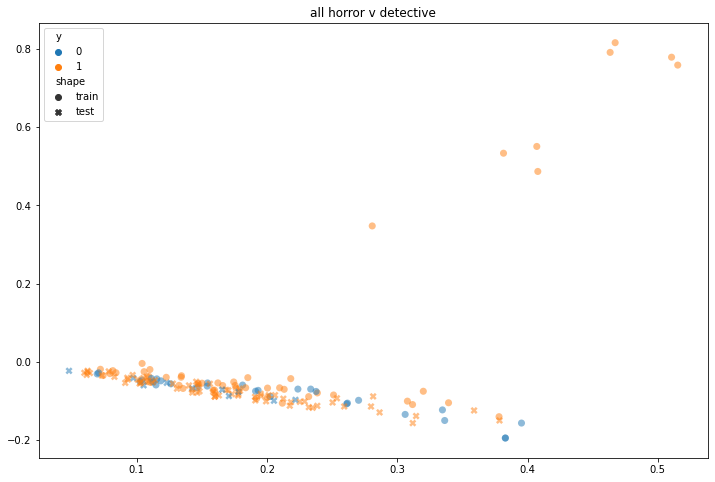

In [41]:
# source: mp2
coords_books = TruncatedSVD(n_components=2).fit_transform(vis)

plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=coords_books[:, 0], 
    y=coords_books[:, 1],
    hue=books_order['y'],
    style=books_order['shape'],
    alpha=0.5,
    s=50,
    linewidth=0
)
plt.title('all horror v detective')
plt.show()

In [80]:
books_order['x_c']=coords_books[:,0]
books_order['y_c']=coords_books[:,1]
no_out=books_order[books_order['y_c']<.3]

In [81]:
out=books_order[books_order['y_c']>.3].title.values
print('outliers:',out)

outliers: ['A Study in Scarlet' 'His Last Bow' 'The Adventures of Sherlock Holmes'
 'The Hound of the Baskervilles' 'The Memoirs of Sherlock Holmes'
 'The Return of Sherlock Holmes' 'The Sign of Four' 'The Valley of Fear']


In [82]:
books_order[(books_order['author1_surname']=='Doyle') | (books_order['author1_surname']=='Conan Doyle') ]

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,regency,manners,philosophical,coming-of-age,filename,shape,y_pred,y,x_c,y_c
2,nca28,tl566,stw43,A Study in Scarlet,1887,Conan Doyle,Arthur,NaN,NaN,male,...,False,False,False,False,ConanDoyle_AStudyInScarlet.txt,train,NaN,1,0.407825,0.486924
14,lqz4,gt294,lcc82,His Last Bow,1917,Conan Doyle,Arthur,NaN,NaN,male,...,False,False,False,False,his_last_bow.txt,train,NaN,1,0.463353,0.791278
20,dk564,NaN,NaN,The Adventures of Sherlock Holmes,1892,Doyle,Conan,NaN,NaN,male,...,False,False,False,False,Doyle_The Adventures of Sherlock Holmes.txt,train,NaN,1,0.510512,0.778976
32,ss3697,gt294,jk2345,The Hound of the Baskervilles,1902,Conan Doyle,Arthur,NaN,NaN,male,...,False,False,False,False,Doyle_TheHoundOfThe Baskervilles.txt,train,NaN,1,0.381487,0.533528
48,yz2685,pav35,avb37,The Memoirs of Sherlock Holmes,1893,Conan Doyle,Arthur,NaN,NaN,male,...,False,False,False,False,memoirs_of_sherlock_holmes.txt,train,NaN,1,0.515251,0.758789
61,sh785,sc2538,sl2324,The Return of Sherlock Holmes,1905,Doyle,Arthur Conan,NaN,NaN,male,...,False,False,False,False,the_return_of_sherlock_holmes.txt,train,NaN,1,0.467202,0.816060
69,yy596,st848,gar234,The Sign of Four,2000,Doyle,Arthur,NaN,NaN,male,...,False,False,False,False,Doyle_TheSignoftheFour.txt,train,NaN,1,0.407042,0.550836
75,tr333,sjs457,sl2324,The Valley of Fear,1915,Doyle,Arthur Conan,NaN,NaN,male,...,False,False,False,False,Doyle_TheValleyOfFear.txt,train,NaN,1,0.280699,0.347666
18,yld3,NaN,NaN,Micah Clarke,1889,Doyle,Arthur Conan,NaN,NaN,male,...,False,False,False,False,Doyle_MicahClarke.txt,test,1.0,1,0.281398,-0.088078


### arthur why

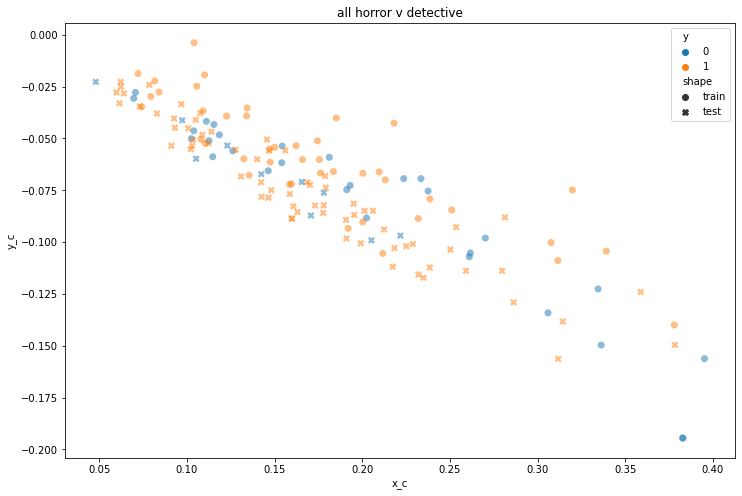

In [83]:
plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=no_out['x_c'],
    y=no_out['y_c'],
    hue=no_out['y'],
    style=no_out['shape'],
    alpha=0.5,
    s=50,
    linewidth=0
)

#ax2 = plt.axes([]
plt.title('all horror v detective')
plt.show()

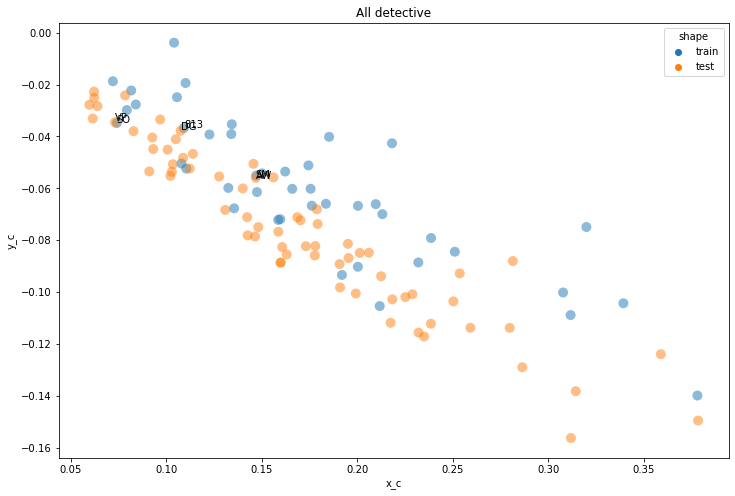

In [84]:
#no_out=books_order[(books_order['y_c']<-.01)&(books_order['x_c']<.07)]
all_det=no_out[no_out['y']==1]
plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=all_det['x_c'],
    y=all_det['y_c'],
    #hue=no_out['y'],
    hue=all_det['shape'],
    alpha=0.5,
    s=100,
    linewidth=0,
)
plt.text(x=0.107421, y=-0.037324, s='DG')
plt.text(x=0.109162, y=-0.036519, s='813')
plt.text(x=0.146958, y=-0.056449, s='AW')
plt.text(x=0.146810, y=-0.055745, s='SM')
plt.text(x=0.073134, y=-0.033966, s='VP')
plt.text(x=0.074059, y=-0.034657, s='SO')




plt.title('All detective')
plt.show()

The orange dots that overlap with the blue dots are books we can recommend to those who like the detective genre.
- Secret of the Old Clock (train) and the Voodoo Planet (test)
- 813 by Maurice LeBlanc (train) and The Picture of Dorian Gray (test)
- Agatha Webb (train) and Silas Marner (test)


In [85]:
all_det[(all_det['y_c']>-.06)&(all_det['y_c']<-.055)&(all_det['x_c']<.155)&(all_det['x_c']>.145)]

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,regency,manners,philosophical,coming-of-age,filename,shape,y_pred,y,x_c,y_c
3,jc2739,NaN,NaN,Agatha Webb,1899,Green,Anna Katharine,NaN,NaN,female,...,False,False,False,False,Green_AgathaWebb.txt,train,NaN,1,0.147030,-0.055073
33,ss3697,gt294,jk2345,Silas Marner,1861,Eliot,George,NaN,NaN,female,...,False,False,False,False,Eliot_SilasMarner.txt,test,1.0,1,0.146838,-0.055969


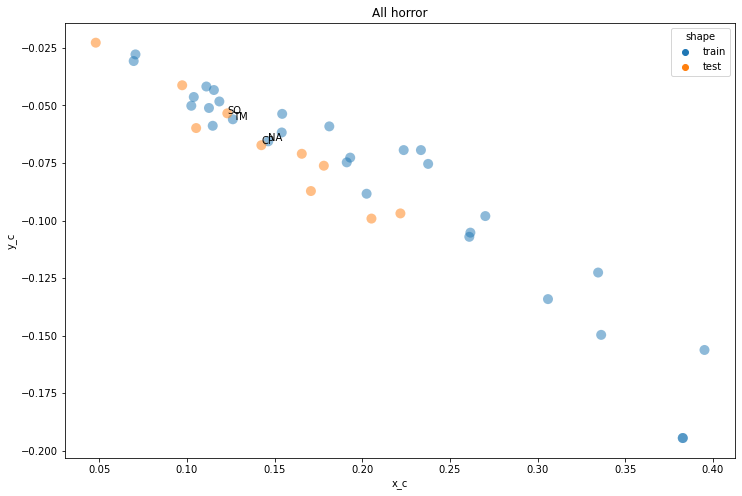

In [86]:
all_hor=books_order[books_order['y']==0]
plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=all_hor['x_c'],
    y=all_hor['y_c'],
   # hue=no_out['y'],
    hue=all_hor['shape'],
    alpha=0.5,
    s=100,
    linewidth=0
)
plt.text(x=0.142446, y=-0.066692, s='CP')
plt.text(x=0.146354, y=-0.065167, s='NA')
plt.text(x=0.126121, y=-0.056002, s='TM')
plt.text(x=0.122982, y=-0.053425, s='SO')
plt.title('All horror')
plt.show()

The orange dots that touch the blue dots are books we can recommend to those who like the horror genre.
- Northanger Abbey (train) and Chaplet of Pearls (test)
- The Man (train) and The Lances of Lynwood (test)

In [87]:
all_hor[(all_hor['y_c']>-.075)&(all_hor['y_c']<-.05)&(all_hor['x_c']<.14)&(all_hor['x_c']>.12)]

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,regency,manners,philosophical,coming-of-age,filename,shape,y_pred,y,x_c,y_c
45,tj256,mn454,ab2226,The Man,1905,Stoker,Bram,NaN,NaN,male,...,False,False,False,False,stoker_theman.txt,train,NaN,0,0.126121,-0.056002
55,avb37,ss3697,yw783,The Lances of Lynwood,1855,Yonge,Charlotte M,NaN,NaN,female,...,False,False,False,False,CMYonge_Lances_Lynwood.txt,test,0.0,0,0.122982,-0.053425


In [88]:
rec_titles=['The Man','The Secret of the Old Clock','Voodoo Planet','813','The Picture of Dorian Gray','Agatha Webb','Silas Marner','Northanger Abbey','Chaplet Of Pearls','The Lances of Lynwood']
book_recs=books_order[books_order['title'].isin(rec_titles)]

In [89]:
book_recs

,Unnamed: 0,check_1,check_2,title,year,author1_surname,author1_givenname,author2_surname,author2_givenname,gender_author1,...,regency,manners,philosophical,coming-of-age,filename,shape,y_pred,y,x_c,y_c
0,tl566,hz542,ja532,813,1910,Leblanc,Maurice,NaN,NaN,male,...,False,False,False,False,Leblanc_813.txt,train,NaN,1,0.109166,-0.036708
3,jc2739,NaN,NaN,Agatha Webb,1899,Green,Anna Katharine,NaN,NaN,female,...,False,False,False,False,Green_AgathaWebb.txt,train,NaN,1,0.147030,-0.055073
18,yy596,st848,gar234,Northanger Abbey,1994,Austen,Jane,NaN,NaN,female,...,False,False,False,False,Austen_NorthangerAbbey.txt,train,NaN,0,0.146357,-0.065577
45,tj256,mn454,ab2226,The Man,1905,Stoker,Bram,NaN,NaN,male,...,False,False,False,False,stoker_theman.txt,train,NaN,0,0.126121,-0.056002
67,thh55,aj656,gc386,The Secret of the Old Clock,1930,Keene,Carolyn,NaN,NaN,female,...,False,False,False,False,keene_secretoftheoldclock.txt,train,NaN,1,0.074076,-0.034807
8,yld3,mab583,NaN,Chaplet Of Pearls,1868,Yonge,Charlotte Mary,NaN,NaN,female,...,False,False,False,False,Yonge_ChapletOfPearls.txt,test,0.0,0,0.142419,-0.067262
33,ss3697,gt294,jk2345,Silas Marner,1861,Eliot,George,NaN,NaN,female,...,False,False,False,False,Eliot_SilasMarner.txt,test,1.0,1,0.146838,-0.055969
55,avb37,ss3697,yw783,The Lances of Lynwood,1855,Yonge,Charlotte M,NaN,NaN,female,...,False,False,False,False,CMYonge_Lances_Lynwood.txt,test,0.0,0,0.122982,-0.053425
63,aac64,lrs263,stw43,The Picture of Dorian Gray,1890,Wilde,Oscar,NaN,NaN,male,...,False,False,True,False,wilde-the-picture-of-dorian-gray.txt,test,1.0,1,0.107482,-0.037805
77,cl2264,NaN,NaN,Voodoo Planet,1959,Norton,Andre,NaN,NaN,female,...,False,False,False,False,Norton_VoodooPlanet.txt,test,1.0,1,0.073105,-0.034554


In [99]:
genres = ['title','shape','y','year','country','author1_surname','gender_author1','x_c','y_c','horror', 'detective', 'sci-fi', 'fantasy', 'romantic', 'gothic', 'historical',
       'feminist fiction', 'mystery', 'adventure', 'tragedy', 'children',
       'regency', 'manners', 'philosophical', 'coming-of-age']

recs=book_recs[genres]
recs=recs.sort_values('x_c').reset_index(drop=True)
recs

,title,shape,y,year,country,author1_surname,gender_author1,x_c,y_c,horror,...,historical,feminist fiction,mystery,adventure,tragedy,children,regency,manners,philosophical,coming-of-age
0,Voodoo Planet,test,1,1959,United States,Norton,female,0.073105,-0.034554,False,...,False,False,False,True,False,False,False,False,False,False
1,The Secret of the Old Clock,train,1,1930,United States,Keene,female,0.074076,-0.034807,False,...,False,False,False,True,False,False,False,False,False,False
2,The Picture of Dorian Gray,test,1,1890,Ireland,Wilde,male,0.107482,-0.037805,False,...,False,False,False,False,False,False,False,False,True,False
3,813,train,1,1910,France,Leblanc,male,0.109166,-0.036708,False,...,False,False,True,False,False,False,False,False,False,False
4,The Lances of Lynwood,test,0,1855,United Kingdom,Yonge,female,0.122982,-0.053425,False,...,True,False,False,False,False,False,False,False,False,False
5,The Man,train,0,1905,United Kingdom,Stoker,male,0.126121,-0.056002,True,...,False,False,False,False,False,False,False,False,False,False
6,Chaplet Of Pearls,test,0,1868,England,Yonge,female,0.142419,-0.067262,False,...,True,False,False,False,False,False,False,False,False,False
7,Northanger Abbey,train,0,1994,United States,Austen,female,0.146357,-0.065577,True,...,False,False,False,False,False,False,False,False,False,False
8,Silas Marner,test,1,1861,United Kingdom,Eliot,female,0.146838,-0.055969,False,...,False,False,False,False,False,False,False,False,False,False
9,Agatha Webb,train,1,1899,United States,Green,female,0.147030,-0.055073,False,...,False,False,True,False,False,False,False,False,False,False


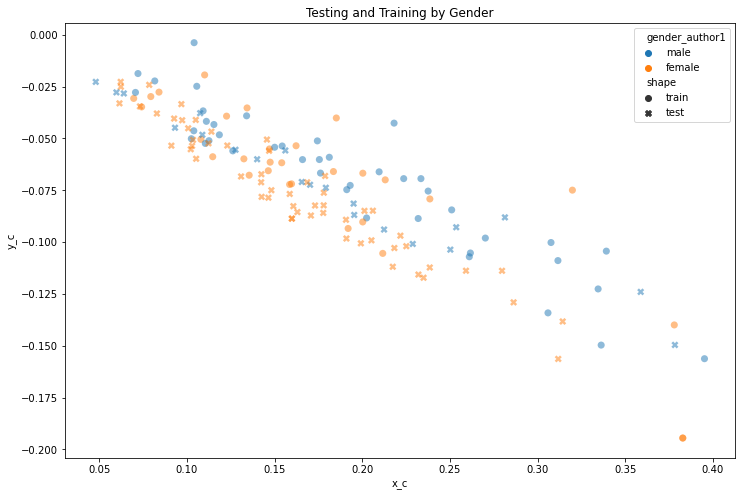

In [92]:
plt.subplots(figsize=(12,8))
sns.scatterplot(
    x=no_out['x_c'], 
    y=no_out['y_c'],
    hue=no_out['gender_author1'],
    style=no_out['shape'],
    alpha=0.5,
    s=50,
    linewidth=0
)
plt.title('Testing and Training by Gender')
plt.show()